In [41]:
##Borrar datos del entorno
rm(list=ls())


#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,srvyr,googledrive,janitor,survey,
               showtext,sf, httr,jsonlite,gt)
#Fuente para los gráficos
font_add_google("Montserrat", "pop")
showtext_auto()

## Funciones para ahorrar código

In [42]:
#Función para consultar la api

consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

In [43]:
#Función para crear mapas
crea_mapa <- function(df, custom_palette, titulo,geodataframe) {
  library(tidyverse)
  library(sf)


datos_planos<-df%>%
#Crear periodos
mutate(periodo=case_when(año>=2013 & año<=2018~"2013-2018",
                        año>=2019 & año<=2023~"2019-2023"))%>%
group_by(periodo,estado)%>%
summarise(acciones=sum(acciones),monto=sum(monto))%>%
ungroup()%>%
#Crear distribución porcentual
group_by(periodo)%>%
mutate(porcentaje=round(acciones/sum(acciones)*100,2))%>%
ungroup()%>%
#Crear cortes para la distribución
mutate(acciones_cat=cut(porcentaje,breaks=5, dig.lab=2))%>%
 #Formato de etiquetas
  mutate(
    etiquetas = if_else(
      str_detect(acciones_cat, "^\\([-]"), 
      str_replace(as.character(acciones_cat), "^\\(\\-", "("), 
      as.character(acciones_cat) 
    ),
  #Guión en lugar de coma
  etiquetas = str_replace(etiquetas, ",", "-"),
  etiquetas = str_replace(etiquetas, "\\]$", ")") 
)%>%
#Unir con geodataframe
left_join(geodataframe, by = c("estado" = "state_name"))

geodata<-datos_planos%>%
st_as_sf()

#Crear mapa
  ggplot() +
  # Capa con datos de los municipios
  geom_sf(data=geodata,aes(fill = etiquetas),
          colour = "#ffffff", size = 0.07) +
  # Agrega título, subtítulo y fuente
  labs(title = titulo,
       subtitle="(Porcentaje)",
       caption = "
Fuente: SEDATU. Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).") +
  scale_fill_manual("%",values = custom_palette)+
  guides(fill = guide_legend(reverse = TRUE)) +
    theme_void()+
  theme(plot.title = element_text(hjust = 0, size=25,face="bold"),
        plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
        plot.caption = element_text(hjust = 0,size=15),
        legend.position="right",
        #Fuente y tamaño
        text=element_text("pop",
                          size=20))+
    facet_wrap(~periodo)

}

In [44]:
#Función para crear tabla
crea_tabla <- function(df, titulo, nombre_archivo) {
  library(gt)
  library(dplyr)
  library(magick)
 
  # Format the numeric columns with commas
  formatted_df <- df %>%
    mutate(across(where(is.numeric), ~scales::comma(.)))

  # Checa si existe la columna "Organismo" para agrupar la tabla
  if("Organismo" %in% names(df)) {
    gt_table <- formatted_df %>%
      gt(rowname_col = "Organismo",
         groupname_col = "Año",
         row_group_as_column = TRUE)
  } else {
    gt_table <- formatted_df %>%
      gt()
  }
  
  gt_table <- gt_table %>%
    tab_options(
      column_labels.font.weight = "bold"
    ) %>%
    tab_header(
      title = md(paste0("**", titulo, "**")),
subtitle=md("*(Número y millones de pesos a precios de 2023)*")
    ) %>%
    tab_options(
      table.font.names = 'Poppins',
      source_notes.font.size = 8,
      table.border.top.width = px(0),
      table.border.bottom.width = px(0),
      column_labels.background.color = "#F0449C"
    ) %>%
    cols_align(
      align = "center"
    ) %>%
    tab_source_note(
      source_note = md("Nota: Cifras preliminares.")
    ) %>%
    tab_source_note(
      source_note = md("Fuente: SEDATU. Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).")
    )

  # Salva la tabla
  gtsave(gt_table, filename = nombre_archivo)

  # Muestra la imagen
  img <- image_read(nombre_archivo)
  return(img)
}

In [45]:
#Función para agrupar datos de manera anual
agrupa_dato_anual <- function(df, columna_tipo_dato) {
  library(dplyr)
#Condición de agrupación  
  if("organismo" %in% names(df)) {
    grouped_df <- df %>%
      group_by(año, organismo)
  } else {
    grouped_df <- df %>%
      group_by(año)
  }
  
  result_df <- grouped_df %>%
    summarise(
      monto = round(sum(monto) / 1000000, 1),
      acciones = sum(acciones),
      .groups = 'drop' 
    ) %>%
    mutate(año = as.character(año)) %>%
    rename(
      "Año" = año,
      "Monto (millones de pesos)" = monto,
      !!columna_tipo_dato := acciones
    )
 
 
 #Renombrar organismo 
  if("organismo" %in% names(df)) {
    result_df <- result_df %>%
      rename("Organismo" = organismo)
  }
  
  return(result_df)
}


In [46]:
#Función para actualizar los precios

actualiza_precios<-function(df,tabla_inpc){

df<-df%>%
#Pegar con tabla de inpc
left_join(tabla_inpc, by = c("Año" = "año"))%>%
#Calcular precios actualizados
#Utilizar columna Monto (millones de pesos) y multiplicar por el inpc correspondiente
mutate(monto_actualizado=round(`Monto (millones de pesos)`*inpc23/100,2))

return(df)

}

In [47]:
paleta<-rev(c("#691c32ff", "#901d3dff","#ac2540ff","#c88f80ff","#e3c8a6ff"))

## Cartografía para generar los mapas

In [48]:
estados<-st_read("https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson")%>%
  #Renombrar Distrito Federal como Ciudad de México
mutate(state_name=case_when(state_name=="Distrito Federal" ~ "Ciudad de México",
TRUE ~ state_name))

Reading layer `states' from data source 
  `https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.4 ymin: 14.5321 xmax: -86.72404 ymax: 32.71865
Geodetic CRS:  WGS 84


### Índice Nacional de Precios al Consumidor

In [49]:
url_inegi<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/628194/es/0700/false/BIE/2.0/ef8c858c-1f87-6408-5630-fb5496f609bf/?type=json"

In [50]:
inpc<-consulta_api(url_inegi)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
#Filtrar fecha
filter(time_period >= "2013/01" & time_period <= "2023/12")%>%
mutate(obs_value=as.numeric(obs_value))%>%
#Extrar mes y año de la variable time_period
separate(time_period, into = c("año", "mes"), sep = "/")%>%
#Dejar solo los datos de diciembre
filter(mes=="12")%>%
arrange(año)%>%
select(año,mes,obs_value)%>%
mutate(
#Cambiar base a 2023
inpc23=obs_value/obs_value[11]*100)
inpc

año,mes,obs_value,inpc23
<chr>,<chr>,<dbl>,<dbl>
2013,12,83.77006,63.28334
2014,12,87.18898,65.86614
2015,12,89.04682,67.26962
2016,12,92.03903,69.53007
2017,12,98.27288,74.23937
2018,12,103.02000,77.82554
2019,12,105.93400,80.02689
2020,12,109.27100,82.54780
2021,12,117.30800,88.61928


## Subsidios

In [51]:
url="https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado"

In [52]:
df<-consulta_api(url)%>%
arrange(año)%>%
  #Filtrar por organismo
  filter(organismo=="CONAVI")%>%
select(-organismo)

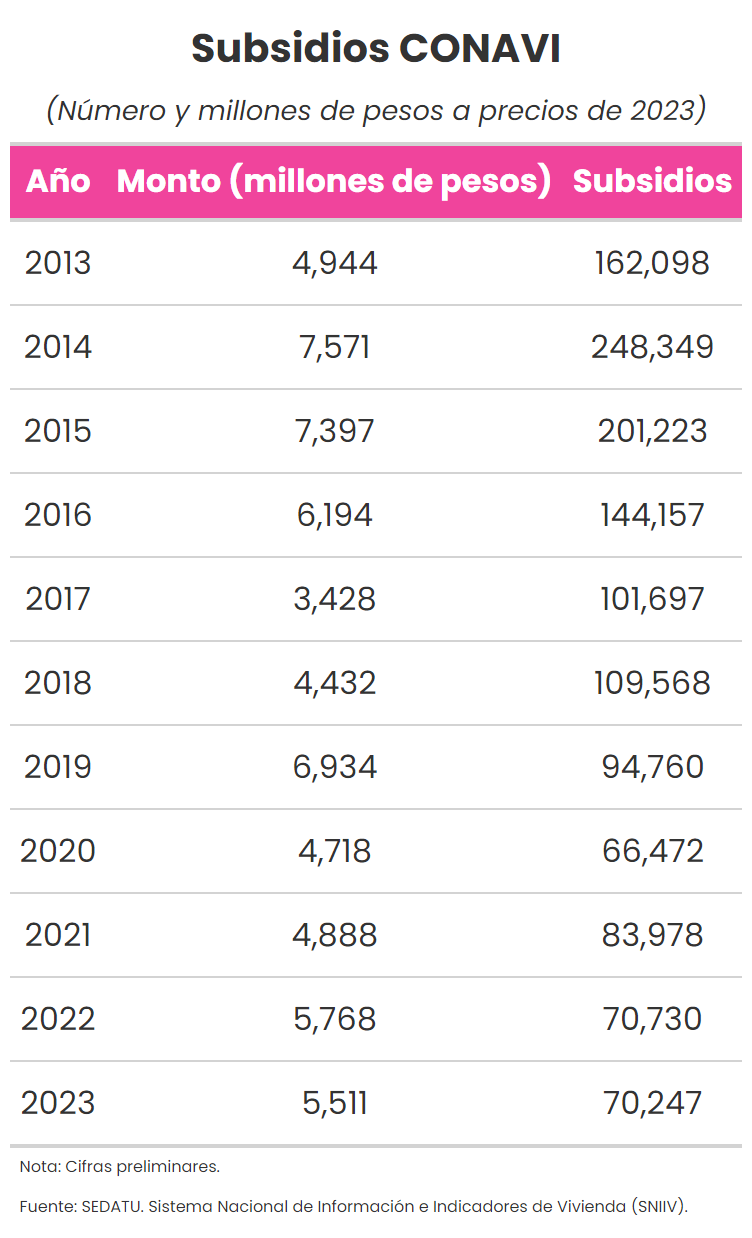

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      752   1238 sRGB       TRUE    105291 72x72  

In [53]:
df%>%
agrupa_dato_anual("Subsidios")%>%
actualiza_precios(inpc)%>%
select(Año, monto_actualizado, Subsidios)%>%
rename("Monto (millones de pesos)" = monto_actualizado)%>%
#Crear tabla
crea_tabla("Subsidios CONAVI","subsidios.png")

### Mapa

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


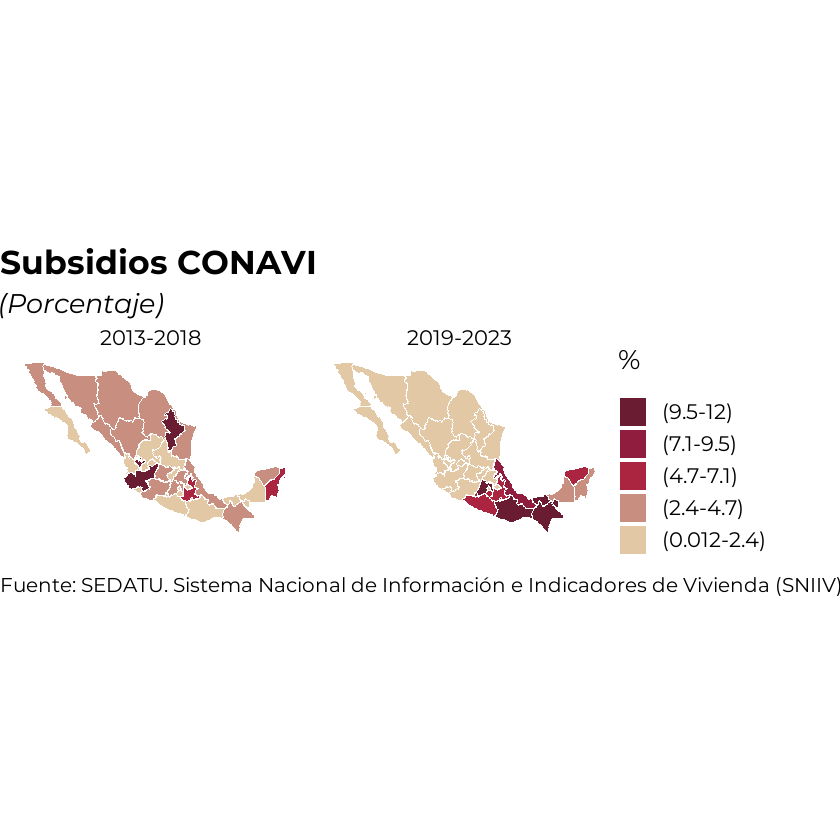

In [54]:
#Crear mapa
crea_mapa(df, paleta, "Subsidios CONAVI",estados)

## Financiamientos

In [55]:
url="https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado"

In [56]:
df<-consulta_api(url)%>%
arrange(año)%>%
  #Filtrar por organismo
  filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE" | organismo=="SHF (FONDEO)")%>%
#Renombrar SHF (FONDEO) como SHF
mutate(organismo=case_when(organismo=="SHF (FONDEO)"~"SHF",
TRUE~organismo))

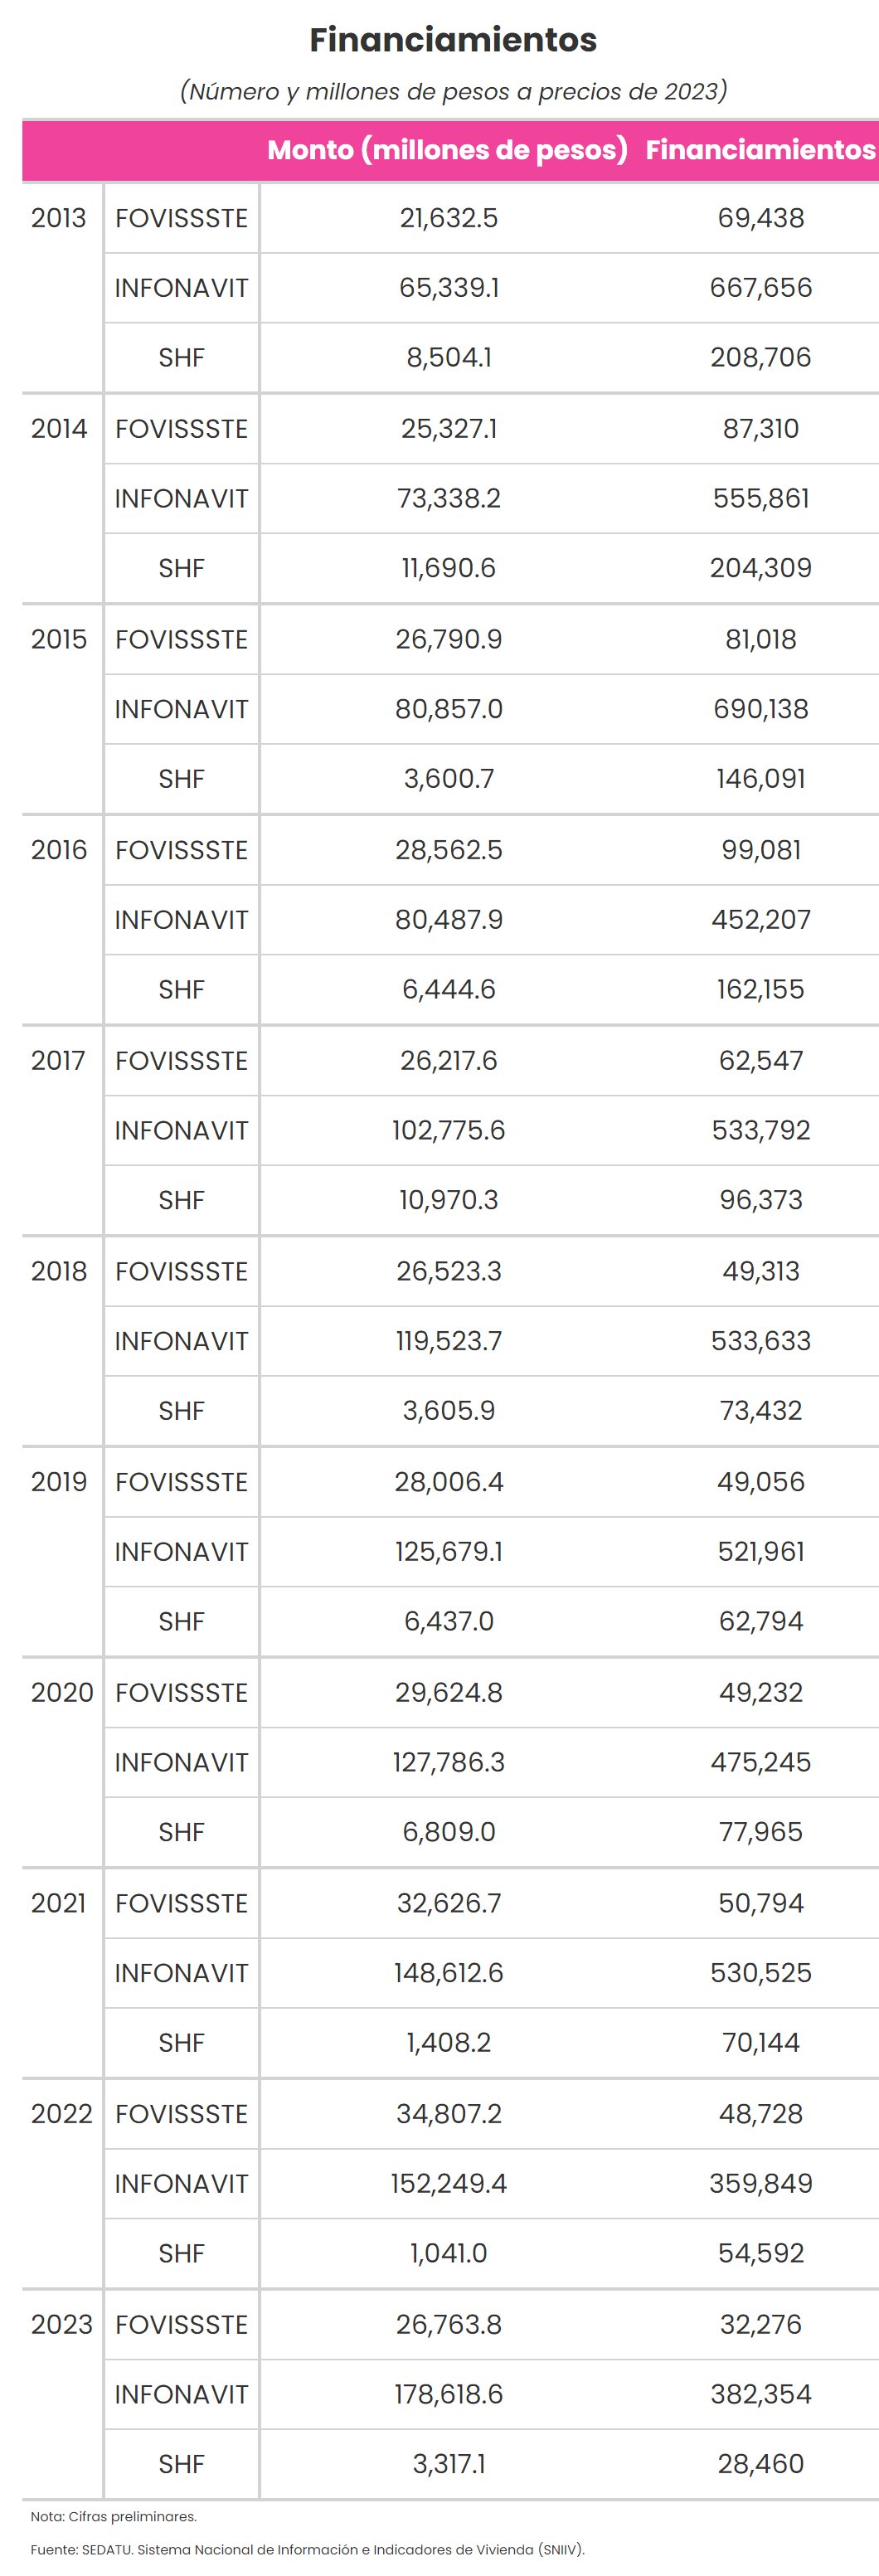

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1060   3106 sRGB       TRUE    305767 72x72  

In [57]:
df%>%
agrupa_dato_anual("Financiamientos")%>%
actualiza_precios(inpc)%>%
select(Año, Organismo, monto_actualizado, Financiamientos)%>%
rename("Monto (millones de pesos)" = monto_actualizado)%>%
#Crear tabla
crea_tabla("Financiamientos","financiamientos.png")

### Mapa

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


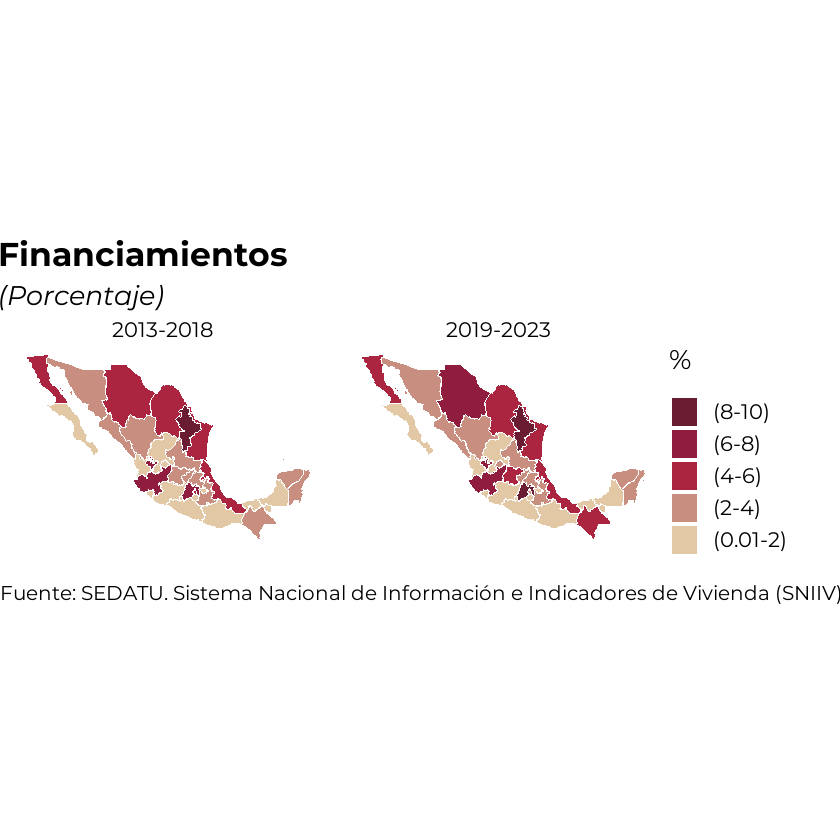

In [58]:
crea_mapa(df, paleta, "Financiamientos",estados)

## Acciones

In [59]:
url="https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado,tipo_credito"

In [60]:
df<-consulta_api(url)%>%
arrange(año)%>%
  #Filtrar por organismo
  filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE" | organismo=="SHF (FONDEO)")%>%
  #Filtrar por tipo de crédito
  filter(tipo_credito=="Credito individual")

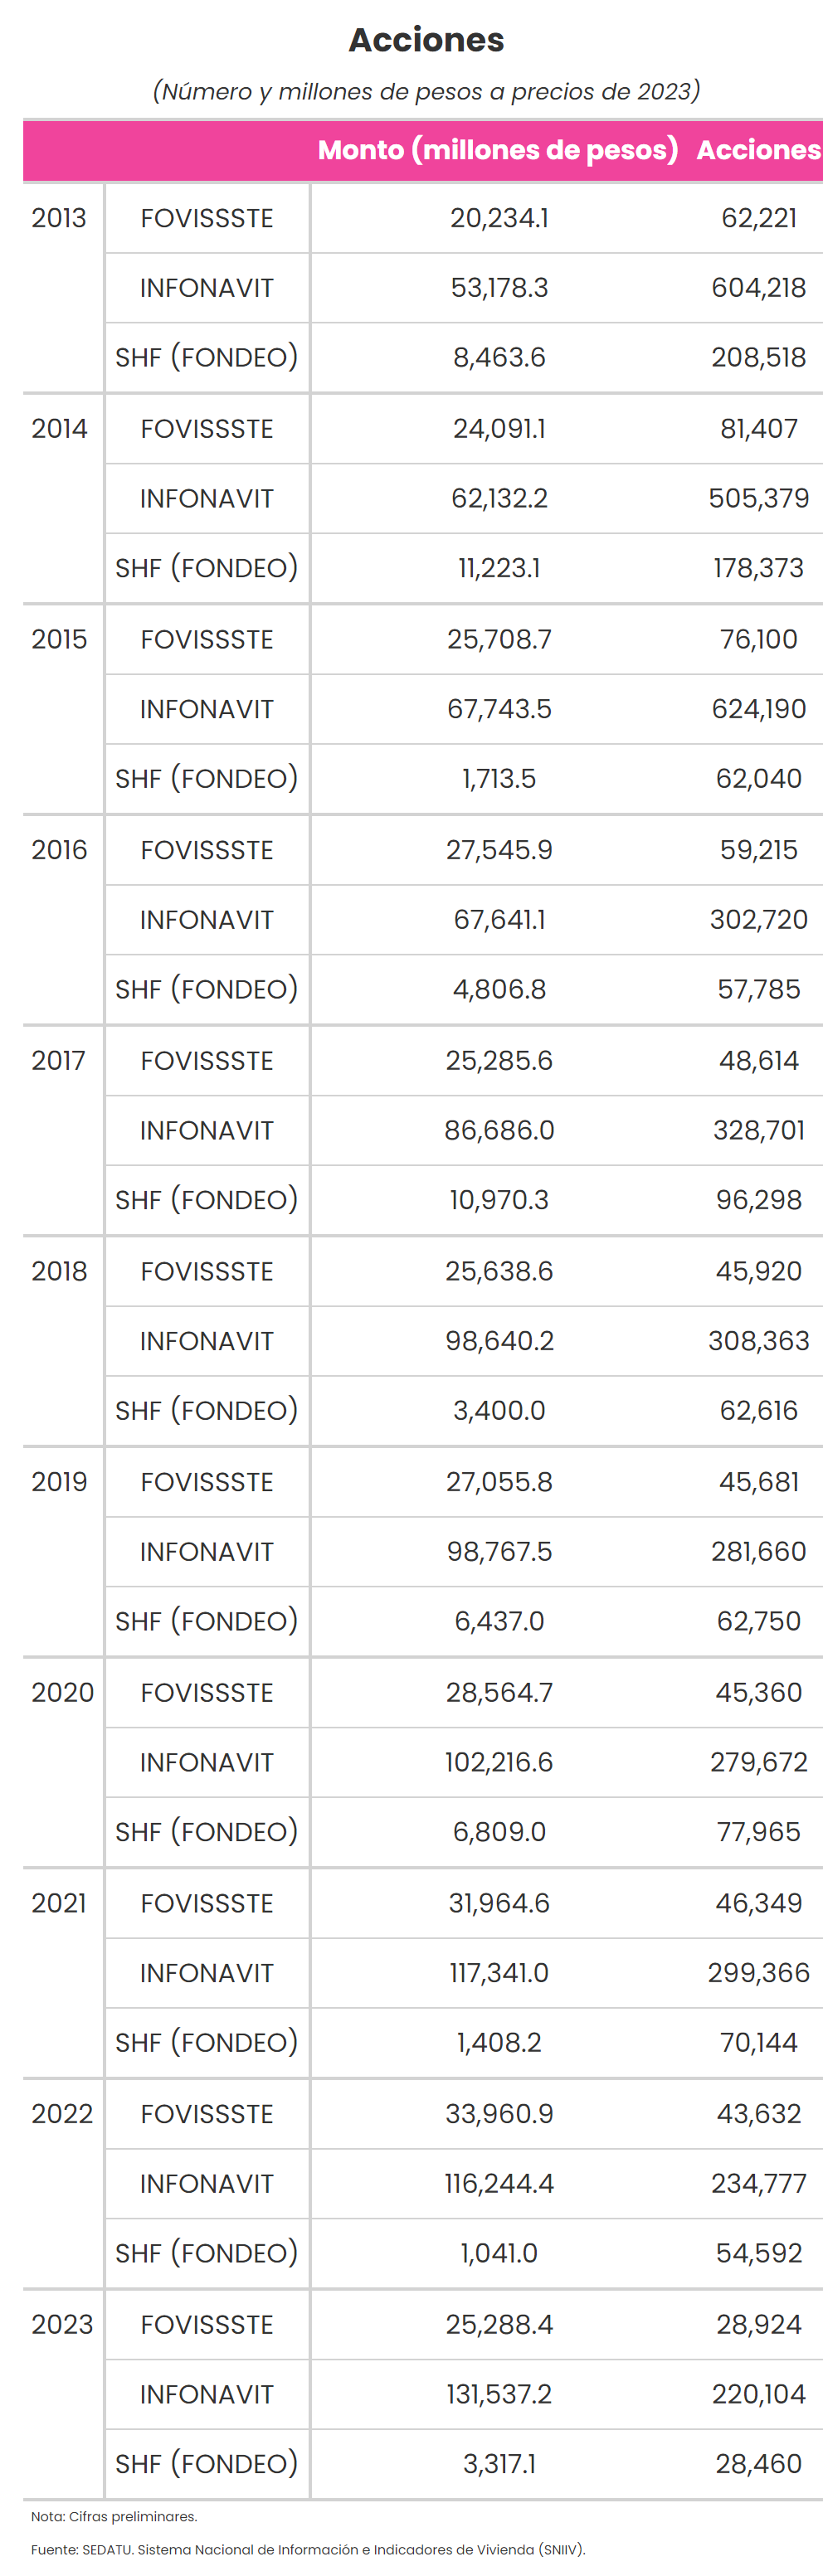

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      992   3106 sRGB       TRUE    335130 72x72  

In [61]:
df%>%
agrupa_dato_anual("Acciones")%>%
actualiza_precios(inpc)%>%
select(Año, Organismo,monto_actualizado, Acciones)%>%
rename("Monto (millones de pesos)" = monto_actualizado)%>%
#Crear tabla
crea_tabla("Acciones","acciones.png")

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


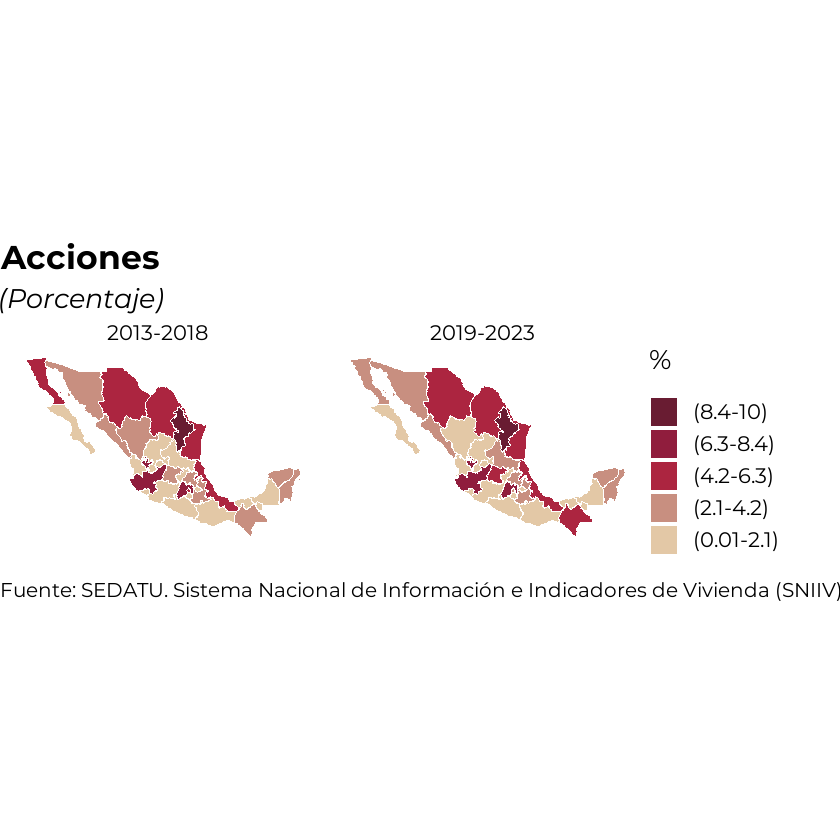

In [62]:
crea_mapa(df, paleta, "Acciones",estados)